In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import gc
import sys
import os
import tqdm
import collections
import re
import correlation_data_utilities
import networkx as nx
from itertools import islice
import copy

Loading BokehJS ...

In [2]:
energyDataDir='energy_topology'
systems=['igps']
variants=['apo','holo']

summaryDataSuffix='decomp_summary.csv'
seriesDataSuffix='energy_series.csv'

nSkip_Summary=6
headerRows_Summary=[0,1]

subDirStr='{system}.{variant}'

dataPrefixStr='{system}.prot_lig_{variant}.mmpbsa.pairwise_decomp'

In [3]:
#lets have a look at the header of one energy summary file

In [4]:
!head 'energy_topology/igps.apo/igps.prot_lig_apo.mmpbsa.pairwise_decomp.decomp_summary.csv'

In [5]:
#The header for the energy summary is rather messy and needs to
#be reformatted to work properly.
def parse_summary_header(headerColumns):
    summaryHead=[]

    head1=''
    for headEntry in headerColumns: #summaryData.columns:
        if not ('Unnamed' in headEntry[0]):
            head1=headEntry[0].replace(' ','_').replace('-','_').replace('.','')
        if 'Unnamed' in headEntry[1]:
            head2=''
        else:
            head2=headEntry[1].replace(' ','_').replace('-','_').replace('.','')
        if head2=='':
            summaryHead.append(head1)
        else:
            summaryHead.append('.'.join([head1,head2]))
    summaryHead=np.array(summaryHead)
    return summaryHead

In [6]:
#lets test it and see if it worked.
#this will also give us a list of columns so we can figure out which ones we need
parse_summary_header(
pd.read_csv(
    'energy_topology/igps.apo/igps.prot_lig_apo.mmpbsa.pairwise_decomp.decomp_summary.csv',
    skiprows=nSkip_Summary,
    header=headerRows_Summary).columns
)

array(['Resid_1', 'Resid_2', 'Internal.Avg', ..., 'TOTAL.Avg',
       'TOTAL.Std_Dev', 'TOTAL.Std_Err_of_Mean'], dtype='<U31')

In [7]:
outputFileName='joint_interaction_energy_summary.TOTAL.csv'
outputFilePath='/'.join([energyDataDir,outputFileName])

system=systems[0]
variant=variants[0]
summaryTables=[]
for system in systems:
    for variant in variants:
        print('--- --- ---')
        print('- Loading',end=', ')
        strDict={
            "system":system,
            "variant":variant,}
        inputPrefix=dataPrefixStr.format(**strDict)
        summaryFileName='.'.join([inputPrefix,summaryDataSuffix])
        print('fileName:',summaryFileName)
        subDir=subDirStr.format(**strDict)
        fileDir='/'.join([energyDataDir,subDir])
        summaryFilePath='/'.join([fileDir,summaryFileName])
        print('filePath:',summaryFilePath)
        summaryData=pd.read_csv(summaryFilePath,skiprows=nSkip_Summary,header=headerRows_Summary)
        print('parsing column names',end=', ')
        summaryData.columns=parse_summary_header(summaryData.columns)
        print('extracting interaction terms',end=', ')
        summaryData['System']=system
        summaryData['Variant']=variant
        summaryData['E_Interact.Mean']=summaryData['TOTAL.Avg'] #(summaryData['van_der_Waals.Avg']+\
                                        # summaryData['Electrostatic.Avg'])
        summaryData['E_Interact.Std_Err']=summaryData['TOTAL.Std_Err_of_Mean'] #(summaryData['van_der_Waals.Std_Err_of_Mean']+\
                                          # summaryData['Electrostatic.Std_Err_of_Mean']).abs()
        summaryData=summaryData[np.concatenate([
            ['System','Variant','Resid_1','Resid_2'],
            [colName for colName in summaryData.columns if 'E_Interact' in colName]
        ])]
        print('formatting residue data columns',end=' -\n')
        summaryData['ResNum_1']=summaryData['Resid_1'].map(
            lambda x: re.sub('[A-Za-z ]','',x))
        summaryData['ResNum_2']=summaryData['Resid_2'].map(
            lambda x: re.sub('[A-Za-z ]','',x))
        summaryData['ResName_1']=summaryData['Resid_1'].map(
            lambda x: re.sub('[0-9 ]','',x))
        summaryData['ResName_2']=summaryData['Resid_2'].map(
            lambda x: re.sub('[0-9 ]','',x))
        summaryData=summaryData.drop(columns=['Resid_1','Resid_2'])
        summaryData=summaryData[np.concatenate([
            ['System','Variant'],
            [colName for colName in summaryData.columns if 'Res' in colName],
            [colName for colName in summaryData.columns if 'Interact' in colName]
        ])]
        summaryTables.append(summaryData.copy())
print('--- --- ---')
print('Done')
summaryData=pd.concat(summaryTables)
del(summaryTables)
summaryData.to_csv(outputFilePath,index=False)
summaryData.head()

--- --- ---
- Loading, fileName: igps.prot_lig_apo.mmpbsa.pairwise_decomp.decomp_summary.csv
filePath: energy_topology/igps.apo/igps.prot_lig_apo.mmpbsa.pairwise_decomp.decomp_summary.csv
parsing column names, extracting interaction terms, formatting residue data columns -
--- --- ---
- Loading, fileName: igps.prot_lig_holo.mmpbsa.pairwise_decomp.decomp_summary.csv
filePath: energy_topology/igps.holo/igps.prot_lig_holo.mmpbsa.pairwise_decomp.decomp_summary.csv
parsing column names, extracting interaction terms, formatting residue data columns -
--- --- ---
Done


,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,5,MET,ARG,-0.019429,0.001980


In [3]:
energyDataDir='energy_topology'
summaryFileName='joint_interaction_energy_summary.TOTAL.csv'
summaryFilePath='/'.join([energyDataDir,summaryFileName])
summaryData=pd.read_csv(summaryFilePath)
summaryData.head()

,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,5,MET,ARG,-0.019429,0.001980


In [9]:
#Use a cutoff of .5 kb*T energy (note, energies from mmpbsa.py are in kcal/mol)
#This is a somewhat arbitrary choice
T_sim=300.15 #room temperature in Kelvins
kb=.0019872041 #Boltzmann's constant in kcal/(mol*K)

thermalEnergy=kb*T_sim
cutoffEnergy=.5*thermalEnergy

#now we want to group by residue pair and filter out any pairs for which
#the absolute value of the interaction mean is not at least 1 standard error
#above the cutoff in any of the systems.
#Conversely if this holds for either system we will keep the pair for ALL systems
#This will allow us to see how much the energy shifted in cases where one system
#has an interaction and the other normally would not.

tqdm.tqdm.pandas(tqdm.tqdm_notebook) #progress bar
#compute a filter value column to speed filtering
print("Generating Grouping Column")
summaryData['ResNumPair']=summaryData[
        ['ResNum_1','ResNum_2']
    ].progress_apply(lambda x: '_'.join(map(str,x)),axis=1)
print("Computing Filter Values")
sig_pairs=summaryData['ResNumPair'][
        (summaryData['E_Interact.Mean'].abs() - \
         summaryData['E_Interact.Std_Err']) > cutoffEnergy
    ].unique()
print('Significant Pairs:',sig_pairs)
sigData=summaryData[summaryData['ResNumPair'].isin(sig_pairs)].drop(columns=['ResNumPair'])
sigData.head()

  4%|▎         | 14654/412232 [00:00<00:05, 71570.15it/s]

Generating Grouping Column


100%|██████████| 412232/412232 [00:05<00:00, 79027.03it/s]


Computing Filter Values
Significant Pairs: ['1_1' '1_2' '1_3' ... '454_424' '454_449' '454_450']


,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
246,igps,apo,1,247,MET,ASN,-1.124520,0.114242


In [10]:
sigData.describe()

,ResNum_1,ResNum_2,E_Interact.Mean,E_Interact.Std_Err
count,11020.000000,11020.000000,11020.000000,11020.000000
mean,229.004719,229.080581,-6.451256,0.100097
std,132.931016,132.934968,19.861023,0.147566
min,1.000000,1.000000,-132.750401,0.000349
25%,113.000000,113.000000,-3.949984,0.031126
50%,228.000000,228.000000,-1.527002,0.055080
75%,344.000000,344.000000,-0.728070,0.093913
max,454.000000,454.000000,177.104258,1.808657


In [11]:
outSigPairName='significant_pairs.TOTAL.txt'
outSigPairPath='/'.join([energyDataDir,outSigPairName])
np.savetxt(fname=outSigPairPath,X=sig_pairs,fmt='%s')
outSigDataName='significant_interactions_summary.TOTAL.csv'
outSigDataPath='/'.join([energyDataDir,outSigDataName])
sigData.to_csv(outSigDataPath,index=False)

In [12]:
nRes=454
outTopMatNameStr='{system}.{variant}.energy_topology_matrix.TOTAL.txt'
outValMatNameStr='{system}.{variant}.energy_value_matrix.TOTAL.txt'
headerComment='# cutoff energy = %.4e kcal/mol'%cutoffEnergy
for groupName,groupData in sigData.groupby(['System','Variant']):
    outMatName=outTopMatNameStr.format(
        system=groupName[0],variant=groupName[1])
    print('saving {matName} to disk'.format(matName=outMatName))
    outMatPath='/'.join([energyDataDir,outMatName])
    outMat=np.savetxt(
        fname=outMatPath,
        X=sp.sparse.coo_matrix(
            (np.array(groupData['E_Interact.Mean'].abs()>0,dtype=float),
             (np.array(groupData['ResNum_1'],dtype=int)-1,
              np.array(groupData['ResNum_2'],dtype=int)-1)),
            shape=(nRes,nRes)).todense())
    
    outMatName=outValMatNameStr.format(
        system=groupName[0],variant=groupName[1])
    print('saving {matName} to disk'.format(matName=outMatName))
    outMatPath='/'.join([energyDataDir,outMatName])
    outMat=np.savetxt(
        fname=outMatPath,
        X=sp.sparse.coo_matrix(
            (np.array(groupData['E_Interact.Mean'].abs()>0,dtype=float),
             (np.array(groupData['ResNum_1'],dtype=int)-1,
              np.array(groupData['ResNum_2'],dtype=int)-1)),
            shape=(nRes,nRes)).todense())
print('done')

saving igps.apo.energy_topology_matrix.TOTAL.txt to disk
saving igps.apo.energy_value_matrix.TOTAL.txt to disk
saving igps.holo.energy_topology_matrix.TOTAL.txt to disk
saving igps.holo.energy_value_matrix.TOTAL.txt to disk
done


# Visualize results

Warning! This next section makes use of NGLVIEW which is not yet supported on Google Colab.

Running cells that use NGLVIEW on google colab will cause the session to crash.

In [4]:
matNameSearchStr='energy_topology_matrix.TOTAL'

matDir='energy_topology'

matFiles=[fileName for fileName in \
          os.listdir(matDir) if \
          matNameSearchStr in fileName]

topologyMatrixDict={}

print('loading topology matrices:',end=' ')
for matFileName in matFiles:
    print(matFileName,end=', ')
    entryKey='.'.join(list(np.array(matFileName.split('.'))[:2]))
    matFilePath='/'.join([matDir,matFileName])
    topologyMatrixDict[entryKey]=np.loadtxt(matFilePath)
print('')

matNameSearchStr='energy_value_matrix.TOTAL'
matFiles=[fileName for fileName in \
          os.listdir(matDir) if \
          matNameSearchStr in fileName]
valueMatrixDict={}
print('loading value matrices:',end=' ')
for matFileName in matFiles:
    print(matFileName,end=', ')
    entryKey='.'.join(list(np.array(matFileName.split('.'))[:2]))
    matFilePath='/'.join([matDir,matFileName])
    valueMatrixDict[entryKey]=np.loadtxt(matFilePath)
print('')

loading topology matrices: igps.holo.energy_topology_matrix.TOTAL.txt, igps.apo.energy_topology_matrix.TOTAL.txt, 
loading value matrices: igps.holo.energy_value_matrix.TOTAL.txt, igps.apo.energy_value_matrix.TOTAL.txt, 


In [5]:

sigPairName='significant_pairs.TOTAL.txt'
sigPairPath='/'.join([energyDataDir,sigPairName])
sigDataName='significant_interactions_summary.TOTAL.csv'
sigDataPath='/'.join([energyDataDir,sigDataName])


sig_pairs=np.loadtxt(sigPairPath,dtype=int)
sigData=pd.read_csv(sigDataPath)

print('sig. pairs:',sig_pairs)
print('Sig. Data:')
sigData.head()

sig. pairs: [    11     12     13 ... 454424 454449 454450]
Sig. Data:


,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,247,MET,ASN,-1.124520,0.114242


In [6]:
for matKey in valueMatrixDict:
    print(matKey,":",
          np.nonzero(valueMatrixDict[matKey])[0].shape,'entries')

igps.holo : (5510,) entries
igps.apo : (5510,) entries


Plotting igps.holo
Plotting igps.apo


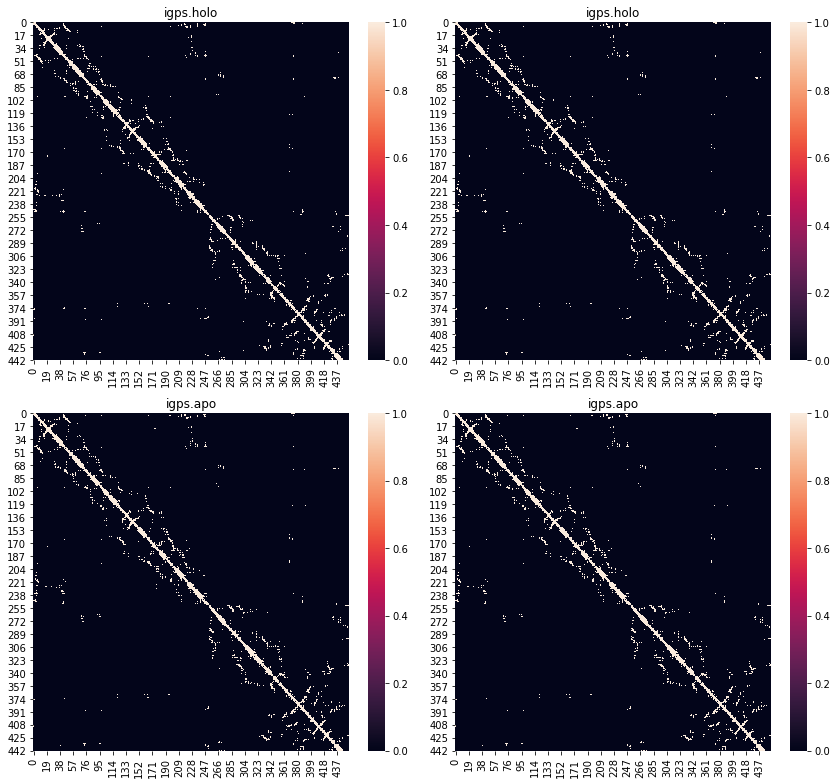

In [15]:
nMats=len(topologyMatrixDict)
fig,axs=plt.subplots(nMats,nMats)

fig.set_figwidth(12)
fig.set_figheight(11)

for iMat,matName in enumerate(topologyMatrixDict.keys()):
    print('Plotting {matName}'.format(matName=matName))
    ax=axs[iMat,0]
    sns.heatmap(topologyMatrixDict[matName],ax=ax)
    ax.set_title(matName)
    
    ax=axs[iMat,1]
    sns.heatmap(valueMatrixDict[matName],ax=ax)
    ax.set_title(matName)
    
plt.tight_layout()

In [9]:
import bokeh as bk
import bokeh.plotting
import bokeh.io
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Title, BasicTicker, ColorBar
from bokeh.models.tools import HoverTool
from bokeh.transform import linear_cmap, factor_cmap, LinearColorMapper
import bokeh.palettes
from bokeh.palettes import Spectral11

In [17]:
nRes=454
for matGroup in sigData.groupby(['System','Variant']):
    print(matGroup[0],matGroup[1].shape)
    
sigData.head()

('igps', 'apo') (5510, 8)
('igps', 'holo') (5510, 8)


,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,247,MET,ASN,-1.124520,0.114242


In [24]:
@interact_manual
def plot_mat(
    system=sigData.System.unique(),
    variant=sigData.Variant.unique(),
    magCut=widgets.FloatSlider(min=.01,max=100.,step=.01,value=2.0,
                               description='Energy_Cut')):
    
    colorMap=np.flip(sns.color_palette("plasma", n_colors=256).as_hex())
    
    plotData=sigData[
        (sigData.System==system) & \
        (sigData.Variant==variant) & \
        ((sigData.ResNum_1 - sigData.ResNum_2).abs() > 0) &
        ((sigData['E_Interact.Mean'].abs()-sigData['E_Interact.Std_Err'])>magCut)]
    
    eMin=plotData['E_Interact.Mean'].min()
    eMax=plotData['E_Interact.Mean'].max()
    cNorm=matplotlib.colors.Normalize(eMin,eMax,clip=True)
    
    plotData['ColorWeight']=plotData['E_Interact.Mean'] #.map(lambda x: cNorm(x)) #.map(np.log10)
    
    #tempCmat=sp.sparse.coo_matrix((
    #    plotData['ColorWeight'],
    #    (plotData.ResNum_1,plotData.ResNum_2)),shape=454,454)
    #tempCmap=matplotlib.cm.get_cmap('Spectral',11)
    
    #drawEdgeColorBar(tempCmat,maskInds=nzInds,
    #             cmap=tempCmap,label='E_Interaction.Mean (kcal/mol)',
    #             cNorm=cNorm,
    #             orientation='horizontal')
    
    p=bk.plotting.figure(
        plot_width=640,plot_height=640,
        #text_font_size='14pt',
        title="{matName} Interaction Energy Heat Map".format(
            matName='.'.join([
                system,variant])))
    
    p.add_layout(Title(text="minimum energy magnitude:{cutVal:.2f} (kcal/mol)".format(
        cutVal=magCut)),'above')
    
    p.xaxis.major_label_text_font_size="14pt"
    p.yaxis.major_label_text_font_size="14pt"
    
    print("Nedges=",len(plotData))
    src=ColumnDataSource(plotData)
    print (src.data.keys())
    print ('min energy: ',plotData['ColorWeight'].min())
    print ('max energy: ',plotData['ColorWeight'].max())
    mapper=linear_cmap(field_name='ColorWeight',
                       palette=colorMap,
                       low=plotData['ColorWeight'].min(),
                       high=plotData['ColorWeight'].max(),
                      )
    
    cbMapper=LinearColorMapper(palette=colorMap,
                               low=plotData['ColorWeight'].min(),
                               high=plotData['ColorWeight'].max(),)
    color_bar = ColorBar(color_mapper=cbMapper, ticker= BasicTicker(),
                     location=(0,0))

    p.add_layout(color_bar, 'right')

    p.rect(source=src,width=1,height=1, x='ResNum_1',y='ResNum_2',
             fill_color=mapper,color=mapper)

    
    
    hover=HoverTool()
    hover.tooltips=[
        (colName,"@{"+"{colName}".format(colName=colName)+"}")
        for colName in src.data.keys()
    ]
    print(hover.tooltips)
    p.add_tools(hover)

    output_notebook()
    show(p)

interactive(children=(Dropdown(description='system', options=('igps',), value='igps'), Dropdown(description='v…

In [25]:
@interact_manual
def plot_mat(
    #system=sigData.System.unique(),
    #variant=sigData.Variant.unique(),
    deltaResNum=widgets.IntSlider(min=0,max=10,step=1,value=1),
    binWidth=widgets.FloatSlider(min=.1,max=10,step=.1,value=1),
    density=[True,False],
    useEbound=[True,False],eBound=widgets.FloatSlider(min=10,max=100,step=1.0,value=50)):
    
    p=bk.plotting.figure(
        plot_width=480,plot_height=480,
        #text_font_size='14pt',
        title="Interaction Energy Histogram")
    
    p.add_layout(Title(text="bin width = {bw:.1f} kT's".format(
        bw=binWidth)),'above')
    
    p.xaxis.major_label_text_font_size="14pt"
    p.yaxis.major_label_text_font_size="14pt"
    
    plotFrames=[]
    
    for system in sigData['System'].unique():
        for variant in sigData['Variant'].unique():
            entryKey='.'.join([system,variant])
            print('binning {Name}'.format(Name=entryKey))
            tempData=sigData[
                (sigData.System==system) & \
                (sigData.Variant==variant) & \
                ((sigData.ResNum_1-sigData.ResNum_2).abs()>=deltaResNum)]['E_Interact.Mean']
            print("Nedges=",len(tempData))
            if useEbound:
                binSet=np.concatenate([[-np.inf],
                                       np.arange(-eBound,eBound,binWidth),
                                       [np.inf]])
            else:
                binSet=np.arange(tempData.min(),tempData.max(),binWidth)
            hist,edges=np.histogram(tempData,
                                    bins=binSet,
                                    density=density)

            if useEbound:
                edges=np.concatenate([
                    [edges[1]-binWidth],
                    edges[1:-1],
                    [edges[-2]+binWidth]])

            plotFrames.append(
                pd.DataFrame({
                    'leftEdge':edges[:-1],
                    'rightEdge':edges[1:],
                    'HistVal':hist,
                    'Name':entryKey
                }))
            
    
    plotData=pd.concat(plotFrames)
    
    src=ColumnDataSource(plotData)

    Names=plotData.Name.unique()
    
    p.quad(source=src,top='HistVal',bottom=0,left='leftEdge',right='rightEdge',
           fill_color=factor_cmap('Name',palette=bk.palettes.Spectral11,factors=Names),
           color=factor_cmap('Name',palette=bk.palettes.Spectral11,factors=Names),
           alpha=.33)

    hover=HoverTool()
    toolTips=[
        (colName,"@{"+"{colName}".format(colName=colName)+"}")
        for colName in src.data.keys()
    ]
    toolTips.append(('(x,y)','($x,$y)'))
    hover.tooltips=toolTips
    print(hover.tooltips)
    p.add_tools(hover)

    output_notebook()
    show(p)

interactive(children=(IntSlider(value=1, description='deltaResNum', max=10), FloatSlider(value=1.0, descriptio…

In [36]:
import nglview as nv
import pytraj as pt

def drawProtNetEdge(protStruc,resID1,resID2,ngViewOb,
                    frame=0,edgeColor=[.5,.5,.5],radius=1,
                    *shapeArgs,**shapeKwargs):
    crd1=pt.center_of_mass(protStruc,':%g@CA'%resID1)[frame]
    crd2=pt.center_of_mass(protStruc,':%g@CA'%resID2)[frame]
    
    
    resname1=protStruc.topology.residue(resID1-1).name
    resid1=protStruc.topology.residue(resID1-1).original_resid
    
    resname2=protStruc.topology.residue(resID2-1).name
    resid2=protStruc.topology.residue(resID2-1).original_resid
    edgeLabel='%s.%g-%s.%g (%g-%g)'%(
        resname1,resid1,resname2,resid2,
        resID1-1,resID2-2)
    
    return ngViewOb.shape.add_cylinder(
        list(crd1),list(crd2),edgeColor,radius,
        edgeLabel,
        *shapeArgs,**shapeKwargs)

def getCorrNetEdgeColors(valMat,maskInds=None,
                         cmap=matplotlib.cm.get_cmap('viridis',1024),
                         cNorm=None,
                         baseColor=[0.,0.,0.]):
    if maskInds is None:
        nzInds=np.nonzero(np.isfinite(valMat))
    else:
        nzInds=maskInds
    
    if cNorm is None:
        vMin=np.min(valMat[nzInds])
        vMax=np.max(valMat[nzInds])
        norm=matplotlib.colors.Normalize(vmin=vMin,vmax=vMax)
    else:
        norm=cNorm
    
    tempCarray=tempCmap(norm(valMat[nzInds]).data)
    edgeColors=np.zeros((valMat.shape[0],valMat.shape[1],3))
    for ii in np.arange(3):
        edgeColors[:,:,ii]=baseColor[ii]
        edgeColors[:,:,ii][nzInds]=tempCarray[:,ii]
    return(edgeColors)

def drawEdgeColorBar(valMat,maskInds=None,
                     cmap=matplotlib.cm.get_cmap('viridis',1024),
                     cNorm=None,
                     ax=None,
                     label='Edge Color Scale',
                     orientation='horizontal',
                     verbose=False):
    if maskInds is None:
        nzInds=np.nonzero(np.isfinite(valMat))
    else:
        nzInds=maskInds
    
    tempCarray=tempCmap(valMat[nzInds])
    if verbose:
        print('vMin:',vMin,'vMax:',vMax)
    
    if cNorm is None:
        vMin=np.min(valMat[nzInds])
        vMax=np.max(valMat[nzInds])
        norm=matplotlib.colors.Normalize(vmin=vMin,vmax=vMax)
    else:
        norm=cNorm
    
    if ax is None:
        if orientation=='horizontal':
            fig = plt.figure(figsize=(16, 4))
            ax1 = fig.add_axes([0.3, 0.80, 0.4, 0.15])
        else:
            fig = plt.figure(figsize=(4, 16))
            ax1 = fig.add_axes([0.3, 0.10, 0.15, 0.4])
    else:
        ax1=ax
    cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=tempCmap,
                                    norm=norm,
                                    orientation=orientation)
    cb1.set_label(label)
    plt.show()

def getCorrNetEdgeRadii(valMat,maskInds=None,
                        eMin=.0625,eMax=.75):
    if maskInds is None:
        nzInds=np.isfinite(valMat)
    else:
        nzInds=maskInds
        
    radiiMat=np.zeros(plotMat.shape)
    radiiMat[nzInds]=np.log(np.abs(np.array(plotMat)[nzInds]))
    rMin=np.min(radiiMat[nzInds])
    rMax=np.max(radiiMat[nzInds])
    rLinFun=lambda x: (x-rMin)/(rMax-rMin)
    rMap=lambda x:(eMax-eMin)*rLinFun(x)+eMin
    radiiMat[nzInds]=rMap(np.array(radiiMat[nzInds]))
    return(radiiMat)

def drawProtCorrMat(protStruc,corrMat,ngViewOb,
                    frame=0,colorsArray=None,radiiMat=None,
                    undirected=True):
    nzInds=np.nonzero(corrMat)
    edgeList=[]
    if not (radiiMat is None):
        radMat=radiiMat
    else:
        radMat=(np.abs(corrMat)>0)*.25
    if undirected:
        indArray=np.array([[ind[0],ind[1]] \
                            for ind in np.array([nzInds[0],nzInds[1]]).T \
                            if ind[0]<ind[1]])
    else:
        indArray=np.array([nzInds[0],nzInds[1]]).T
    for nzInd in indArray:
        if not (colorsArray is None):
            colorParm={'edgeColor':list(colorsArray[nzInd[0],nzInd[1],:])}
        else:
            colorParm={}
        edgeList.append(drawProtNetEdge(
            protStruc,nzInd[0]+1,nzInd[1]+1,
            ngViewOb,frame,radius=radMat[nzInd[0],nzInd[1]],
            **colorParm))
    return edgeList

In [39]:
import pytraj as pt
strucDataDir='energy_topology'
systems=['igps']
variants=['apo','holo']

strucFileNameStr="{system}.prot_lig_{variant}.pdb"

subDirStr='{system}.{variant}'

strucDict={}
for system in systems:
    for variant in variants:
        subDir=subDirStr.format(system=system,variant=variant)
        strucFileName=strucFileNameStr.format(system=system,variant=variant)
        strucFilePath='/'.join([strucDataDir,subDir,strucFileName])
        strucKey=subDir
        print("loading",strucKey)
        strucDict[strucKey]=pt.load(strucFilePath)
print(strucDict)

loading igps.apo
loading igps.holo
{'igps.apo': pytraj.Trajectory, 1 frames: 
Size: 0.000161 (GB)
<Topology: 7225 atoms, 456 residues, 4 mols, PBC with box type = ortho>
           , 'igps.holo': pytraj.Trajectory, 1 frames: 
Size: 0.000163 (GB)
<Topology: 7281 atoms, 455 residues, 3 mols, PBC with box type = ortho>
           }


In [37]:
system='igps'
variant='apo'
nRes=454
Tsim=310.15
kb=0.0019872041
magCut=kb*Tsim*1.0
seqDelta=0
#filter out desired interaction energy edges based
#for the given system based upon energy and
#sequence delta cutoffs
matData=sigData[
    (sigData['System']==system) & \
    (sigData['Variant']==variant) & \
    ((sigData['ResNum_1']-sigData['ResNum_2'])<seqDelta) &
    ((sigData['E_Interact.Mean'].abs() - sigData['E_Interact.Std_Err']) > magCut)]
tempMat=sp.sparse.coo_matrix(
    (matData['E_Interact.Mean'],
     (matData['ResNum_1']-1,matData['ResNum_2']-1)))
plotMat=np.abs(tempMat.todense())

print("Nedges=",len(np.nonzero(tempMat)[0]))

nzInds=np.nonzero(plotMat)

#Create a color map for edges based on log(abs(E_Interact.Mean))
tempCmap=matplotlib.cm.get_cmap('Spectral',2048)
tempCmat=np.array((tempMat.todense()))
vMin=np.min(tempCmat)
vCenter=0
vMax=np.max(tempCmat)
cNorm=matplotlib.colors.DivergingNorm(vmin=vMin,vcenter=vCenter,vmax=vMax)
#tempCmat[nzInds]=np.log(tempCmat[nzInds])
edgeColors=getCorrNetEdgeColors(tempCmat,maskInds=nzInds,cmap=tempCmap,
                                cNorm=cNorm)

#Compute widths for edges based on lob(abs(E_Interact.Mean))
#rMin and rMax set minimum and maximum edgewidths
#edgwidth will then interpolate linearly between those two
#bounds.
eMin=.125
eMax=0.625
radiiMat=getCorrNetEdgeRadii(plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)

Nedges= 1994


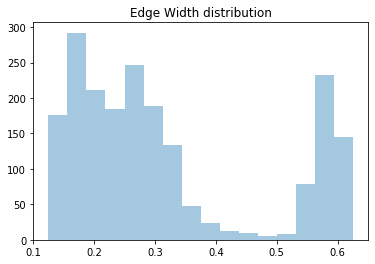

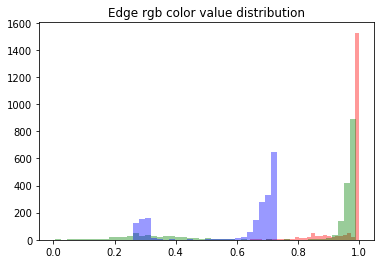

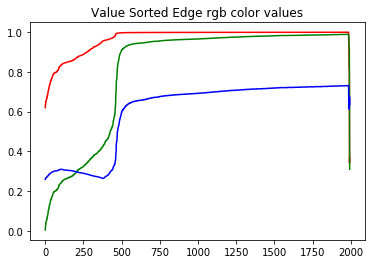

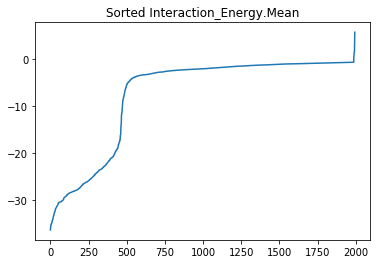

In [38]:
#Plot distribution histograms for edge widths and edge color rgb values
sns.distplot(radiiMat[np.nonzero(radiiMat)].flatten(),
             kde=False)
plt.title('Edge Width distribution')
plt.show()

clist=['red','green','blue']
for ii in np.arange(3):
    sns.distplot(edgeColors[:,:,ii][np.nonzero(edgeColors[:,:,ii])].flatten(),
                 kde=False,color=clist[ii])
plt.title('Edge rgb color value distribution')
plt.show()

sortArr=np.argsort(tempCmat[np.nonzero(tempCmat)])
sortedInds=np.array(list(zip(nzInds[0],nzInds[1])))[sortArr]
sortedNzInds=(sortedInds[:,0],sortedInds[:,1])

clist=['red','green','blue']
for ii in np.arange(3):
    plt.plot(edgeColors[:,:,ii][sortedNzInds],c=clist[ii])
plt.title('Value Sorted Edge rgb color values')
plt.show()

plt.plot(tempCmat[sortedNzInds])
plt.title('Sorted Interaction_Energy.Mean')
plt.show()

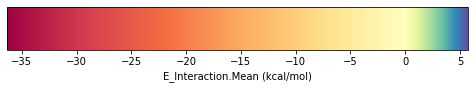

NGLWidget()

In [39]:
from IPython.display import display, HTML

CSS = """
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

#Draw a color bar for the edge coloring,
#(nglview does not seem to support this yet)
drawEdgeColorBar(tempCmat,maskInds=nzInds,
                 cmap=tempCmap,label='E_Interaction.Mean (kcal/mol)',
                 cNorm=cNorm,
                 orientation='horizontal')

#Render the filtered interaction network using nglview with
#the edge width and colormaps generated above
struc=strucDict[list(strucDict.keys())[0]]
view=nv.show_pytraj(struc)
view.clear_representations()
view.add_representation('cartoon',alpha=.5)
drawProtCorrMat(protStruc=struc,corrMat=plotMat,ngViewOb=view,
                    frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
                    undirected=True)
view

In [26]:
#In order to apply current flow betweenness methods, we need one or more source
#and target residues.
#For IGPS, two well known interaction residues are LEU50 (Allosteric Ligand biniding pocket)
#and GLU 180 (active site residue)
#Our structure here has 2 chains, the first is the allosteric region and the
#second contains the active site.
#The allosteric region is 253 residues long... and numbering in python starts at 0
#so our two residues of interest are 50-1 = 49
#and 253+180-1=432
#So residues 49 and 432 will serve as the source and target residues repsectively
struc=strucDict[list(strucDict.keys())[0]]
print (struc.topology.residue(50-1))
print (struc.topology.residue(253+180-1))
sourceSet=[49]
targetSet=[432]

<LEU49, 19 atoms>
<GLU432, 15 atoms>


In [104]:
def converge_subopt_paths_betweenness(inputNetwork,source,target,weight='weight',
                                      maxPaths=100,tolerance=1e-6,
                                      giveAlphas=False,verbose=False):
    '''Take additional paths between a source / target pair until the betweenness
       centrality of nodes within those paths computed over the attained suboptimal paths
       converges to a given tolerance.
       the convergence critera 'alpha' is computed as:
       alpha = (sum(current path node usage counts) / (number of paths + sum(all path node usage counts))
       the function will return a list of all generated paths. If the "giveAlphas" option is
       turned on, it will also return a list of the alpha after each iteration (path generated)
       this is useful for comparing convergence over different weighting schemes.
       if the "verbose" option is turned on, the alpha after each iteration will be printed
       to standard out as calculation proceeds.'''
    nNodes=len(inputNetwork.nodes())
    pathGenerator=nx.shortest_simple_paths(inputNetwork, source, target, weight=weight)
    nodeCounts=np.zeros(nNodes)
    pathList=[]
    alphas=[]
    newPath=next(pathGenerator)
    pathList.append(copy.deepcopy(newPath))
    pathCounts=np.unique(newPath,return_counts=True)
    tempCounts=np.zeros(nNodes)
    tempCounts[pathCounts[0]]=pathCounts[1]
    nPaths=1
    alpha=np.sum(tempCounts)/np.sum(nodeCounts+tempCounts)/nPaths*1.
    alphas.append(alpha)
    if verbose:
            print("%.3e"%alpha,end=", ")
    while (alpha>tolerance) & (nPaths<maxPaths):
        nodeCounts+=tempCounts
        
        newPath=next(pathGenerator)
        pathList.append(copy.deepcopy(newPath))
        pathCounts=np.unique(newPath,return_counts=True)
        tempCounts=np.zeros(nNodes)
        tempCounts[pathCounts[0]]=pathCounts[1]
        nPaths+=1
        alpha=np.sum(tempCounts)/np.sum(nodeCounts+tempCounts)/nPaths*1.0
        alphas.append(alpha)
        if verbose:
            print("%.3e"%alpha,end=", ")
    if alpha>tolerance:
        print("Maximum number of paths reached before converging betweenness score")
        print("Last relative count delta: %.3e"%alpha)
    if giveAlphas:
        return((pathList,alphas))
    else:
        return(pathList)

def calculatePathLength(pathGraph,path,weight='weight'):
    return(np.sum([pathGraph.edges()[(edge[0],edge[1])][weight] \
                   for edge in zip(path[:-1],path[1:])]))

In [93]:
system='igps'
variant='apo'
nRes=454
Tsim=310.15
kb=0.0019872041
magCut=kb*Tsim*1.0
seqDelta=0
#filter out desired interaction energy edges based
#for the given system based upon energy and
#sequence delta cutoffs
matData=sigData[
    (sigData['System']==system) & \
    (sigData['Variant']==variant) & \
    ((sigData['ResNum_1']-sigData['ResNum_2'])<seqDelta) &
    ((sigData['E_Interact.Mean'].abs() - sigData['E_Interact.Std_Err']) > magCut)]
tempMat=sp.sparse.coo_matrix(
    (matData['E_Interact.Mean'],
     (matData['ResNum_1']-1,matData['ResNum_2']-1)),
    shape=(454,454))
wMat=tempMat.todense()
nzInds=np.nonzero(tempMat)
wMat[nzInds]=1./(np.abs(wMat[nzInds]))
wMat=np.array(wMat)
wMatGraph=nx.from_numpy_array(wMat)

In [105]:
pathList,alphas=converge_subopt_paths_betweenness(wMatGraph,source=49,target=432,maxPaths=10000,
                                                  verbose=True,giveAlphas=True)
print(pathList)
pathLengths=[calculatePathLength(wMatGraph,path) for path in pathList]
print(pathLengths)

1.000e+00, 2.750e-01, 1.111e-01, 6.250e-02, 4.615e-02, 3.333e-02, 2.068e-02, 1.190e-02, 1.587e-02, 1.091e-02, 1.091e-02, 5.013e-03, 4.364e-03, 3.835e-03, 7.186e-03, 3.862e-03, 2.226e-03, 2.025e-03, 3.338e-03, 2.982e-03, 2.680e-03, 2.422e-03, 1.380e-03, 1.894e-03, 1.877e-03, 1.080e-03, 1.496e-03, 1.276e-03, 1.189e-03, 1.305e-03, 1.125e-03, 9.683e-04, 1.070e-03, 1.004e-03, 9.427e-04, 6.876e-04, 9.676e-04, 7.327e-04, 9.178e-04, 7.592e-04, 5.684e-04, 7.806e-04, 5.127e-04, 6.632e-04, 5.070e-04, 4.453e-04, 6.529e-04, 5.848e-04, 3.519e-04, 4.054e-04, 3.896e-04, 3.746e-04, 3.900e-04, 2.898e-04, 4.170e-04, 4.004e-04, 3.344e-04, 3.952e-04, 2.158e-04, 2.782e-04, 2.470e-04, 2.822e-04, 1.900e-04, 2.454e-04, 1.988e-04, 2.123e-04, 2.615e-04, 3.591e-04, 2.607e-04, 2.524e-04, 2.445e-04, 1.274e-04, 3.221e-04, 1.348e-04, 1.172e-04, 2.134e-04, 1.800e-04, 1.753e-04, 1.317e-04, 1.668e-04, 1.749e-04, 1.101e-04, 1.668e-04, 1.396e-04, 9.129e-05, 1.006e-04, 1.419e-04, 1.175e-04, 2.073e-04, 2.309e-04, 8.862e-05,

In [96]:
len(pathList)

701

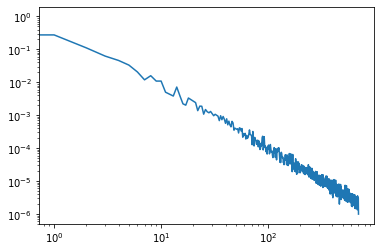

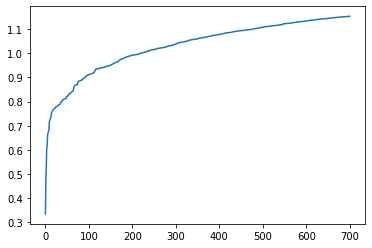

In [109]:
plt.plot(alphas)
plt.loglog()
plt.show()
plt.plot(pathLengths)
plt.show()

In [130]:
system='igps'
variant='apo'
nRes=454
Tsim=310.15
kb=0.0019872041
magCut=kb*Tsim*1.0
seqDelta=0
#filter out desired interaction energy edges based
#for the given system based upon energy and
#sequence delta cutoffs
matData=sigData[
    (sigData['System']==system) & \
    (sigData['Variant']==variant) & \
    ((sigData['ResNum_1']-sigData['ResNum_2'])<seqDelta) &
    ((sigData['E_Interact.Mean'].abs() - sigData['E_Interact.Std_Err']) > magCut)]
tempMat=sp.sparse.coo_matrix(
    (matData['E_Interact.Mean'],
     (matData['ResNum_1']-1,matData['ResNum_2']-1)),
    shape=(454,454))
datMat=np.abs(tempMat.todense())
nzInds=np.nonzero(datMat)

btwMat=np.array(correlation_data_utilities.getBtwMat(
    datMat,sources=sourceSet,targets=targetSet,verbose=False,verboseLevel=0,
    useProgressBar=True,pbarFun=tqdm.tqdm_notebook))
btwMat

array([[0.00000000e+00, 7.97155396e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.15182756e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.18408751e-17, 6.88952454e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.09865871e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [131]:
btwWeightMat=copy.deepcopy(btwMat+btwMat.T)
btwWeightMat=np.array(btwWeightMat)
nzInds=np.nonzero(btwWeightMat)
btwWeightMat[nzInds]=-np.log(btwWeightMat[nzInds])
btwWeightGraph=nx.from_numpy_array(btwWeightMat)

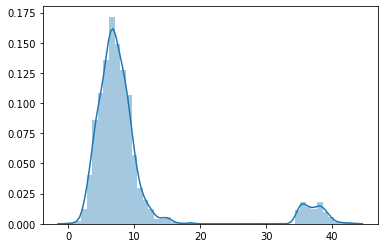

0.1811791377471204 9.474298649677799 42.87043160619085


In [134]:
btwWeights=[btwWeightGraph.edges()[edge]['weight'] for edge in btwWeightGraph.edges()]
sns.distplot(btwWeights)
plt.show()
print(np.min(btwWeights),np.mean(btwWeights),np.max(btwWeights))

In [135]:
btwPathList,btwAlphas=converge_subopt_paths_betweenness(btwWeightGraph,source=49,target=432,maxPaths=10000,
                                                  verbose=True,giveAlphas=True)
print(btwPathList)
btwPathLengths=[calculatePathLength(btwWeightGraph,path) for path in btwPathList]
print(btwPathLengths)

1.000e+00, 2.500e-01, 1.111e-01, 6.250e-02, 4.516e-02, 2.703e-02, 1.993e-02, 1.531e-02, 1.389e-02, 9.677e-03, 8.021e-03, 7.778e-03, 6.567e-03, 4.870e-03, 4.912e-03, 3.713e-03, 3.813e-03, 3.382e-03, 3.020e-03, 2.713e-03, 2.451e-03, 2.225e-03, 2.303e-03, 1.846e-03, 1.463e-03, 1.574e-03, 1.457e-03, 1.351e-03, 1.257e-03, 1.010e-03, 1.253e-03, 1.168e-03, 9.598e-04, 9.030e-04, 8.511e-04, 8.035e-04, 8.649e-04, 7.168e-04, 6.799e-04, 6.458e-04, 6.141e-04, 5.848e-04, 5.575e-04, 5.321e-04, 4.372e-04, 4.877e-04, 4.014e-04, 4.487e-04, 4.303e-04, 4.706e-04, 3.955e-04, 3.803e-04, 4.170e-04, 4.004e-04, 4.318e-04, 3.238e-04, 3.125e-04, 3.860e-04, 2.901e-04, 2.804e-04, 2.331e-04, 3.001e-04, 2.543e-04, 2.809e-04, 2.383e-04, 2.635e-04, 2.237e-04, 2.172e-04, 2.109e-04, 2.337e-04, 2.267e-04, 1.929e-04, 2.403e-04, 1.819e-04, 2.020e-04, 1.722e-04, 2.149e-04, 1.629e-04, 1.588e-04, 1.767e-04, 1.721e-04, 1.883e-04, 1.429e-04, 1.396e-04, 1.363e-04, 1.332e-04, 1.302e-04, 1.452e-04, 1.418e-04, 1.385e-04, 1.352e-04,

2.191e-06, 2.184e-06, 1.743e-06, 1.738e-06, 1.950e-06, 1.729e-06, 1.940e-06, 1.934e-06, 1.929e-06, 1.923e-06, 2.131e-06, 1.488e-06, 1.908e-06, 1.903e-06, 1.897e-06, 1.892e-06, 1.887e-06, 1.464e-06, 1.669e-06, 1.872e-06, 1.660e-06, 2.069e-06, 1.857e-06, 1.646e-06, 1.847e-06, 1.842e-06, 1.837e-06, 2.035e-06, 1.624e-06, 1.620e-06, 1.414e-06, 1.813e-06, 1.608e-06, 2.004e-06, 1.998e-06, 1.993e-06, 1.590e-06, 1.586e-06, 1.582e-06, 1.578e-06, 1.967e-06, 1.766e-06, 1.566e-06, 1.757e-06, 1.558e-06, 1.554e-06, 1.937e-06, 1.352e-06, 1.927e-06, 1.921e-06, 1.533e-06, 1.529e-06, 1.716e-06, 1.522e-06, 1.518e-06, 1.703e-06, 1.322e-06, 1.695e-06, 1.690e-06, 1.499e-06, 1.495e-06, 1.678e-06, 1.302e-06, 1.484e-06, 1.296e-06, 1.477e-06, 1.658e-06, 1.654e-06, 1.649e-06, 1.645e-06, 1.641e-06, 1.455e-06, 1.814e-06, 1.628e-06, 1.444e-06, 1.620e-06, 1.437e-06, 1.612e-06, 1.608e-06, 1.604e-06, 1.600e-06, 1.773e-06, 1.415e-06, 1.764e-06, 1.584e-06, 1.404e-06, 1.751e-06, 1.572e-06, 1.568e-06, 1.217e-06, 1.214e-06,

[15.274645166456583, 15.389992835290709, 15.751035702656036, 15.84897649927365, 16.00765233833954, 16.486297459050725, 16.791914034909997, 17.16339219181134, 17.275070786323504, 17.366245367727064, 17.39231446626448, 17.52492120679295, 17.653878712053793, 17.737723524628407, 17.757788306719373, 17.76379262316582, 17.896399363694293, 18.03067072093452, 18.062607624594705, 18.1467542411148, 18.22821004487086, 18.262101909948928, 18.386885883936746, 18.423650491960036, 18.504283233370728, 18.519086214169846, 18.538584326684003, 18.623144777314256, 18.673403965806482, 18.71078323998443, 18.768068353519432, 18.78430558232356, 18.792339654776917, 18.819734727015806, 18.87449557457263, 18.879690170888804, 18.879761412997755, 18.880129081535177, 18.899627194049334, 19.014509810011283, 19.03444683317181, 19.074829847987978, 19.093417546986913, 19.163817811678257, 19.204648660677947, 19.21384959412468, 19.226792690132854, 19.23553844193796, 19.24773529862355, 19.252093386052803, 19.2750571751727

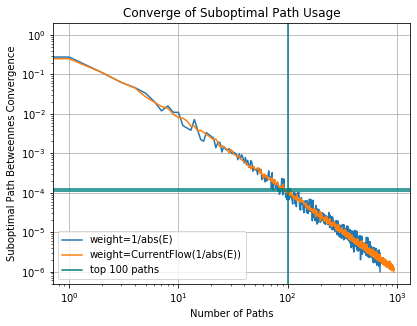

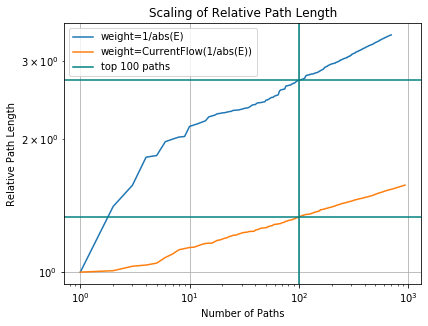

In [254]:
plt.figure(figsize=(6.4,4.8))
plt.plot(alphas,label='weight=1/abs(E)')
plt.plot(btwAlphas,label='weight=CurrentFlow(1/abs(E))')
plt.axvline(100,color='teal',label='top 100 paths')
plt.axhline(alphas[99],color='teal')
plt.axhline(btwAlphas[99],color='teal')
plt.loglog()
plt.legend(loc="lower left")
plt.xlabel('Number of Paths')
plt.ylabel('Suboptimal Path Betweennes Convergence')
plt.title("Converge of Suboptimal Path Usage")
plt.grid()
plt.show()

plt.figure(figsize=(6.4,4.8))
plt.plot(np.arange(len(pathLengths))+1,
         pathLengths/np.min(pathLengths),
         label='weight=1/abs(E)')
plt.plot(np.arange(len(btwPathLengths))+1,
         btwPathLengths/np.min(btwPathLengths),
         label='weight=CurrentFlow(1/abs(E))')
plt.axvline(100,color='teal',label='top 100 paths')
plt.axhline(pathLengths[99]/pathLengths[0],color='teal')
plt.axhline(btwPathLengths[99]/btwPathLengths[0],color='teal')
plt.loglog()
plt.legend(loc="upper left")
plt.xlabel('Number of Paths')
plt.ylabel('Relative Path Length')
plt.title("Scaling of Relative Path Length")
plt.grid()
plt.show()

In [29]:
path=btwPathList[0]
pathNz=(path[1:],path[:-1])

resNumMap=lambda x: x-253*(x>=253)+1
resChainMap=lambda x: ['A','B'][int(x>=253)]
print("Shortest path length (LEU_50 - GLU180):",btwPathLengths[0])
print('Path (edge list):',[tuple(np.flip(edge)) for edge in zip(*pathNz)])
print('Path (Node Sequence Residue Names):',
      [struc.topology.residue(iRes).name + "_" + \
       resChainMap(struc.topology.residue(iRes).index) + "_" + \
       str(resNumMap(struc.topology.residue(iRes).index)) \
       for iRes in np.flip(np.array(path))])

NameError: name 'btwPathList' is not defined

In [187]:
plotMat=np.zeros(btwMat.shape)
plotMat[pathNz]=(btwMat+btwMat.T)[pathNz]

print("Nedges=",len(np.nonzero(plotMat)[0]))

nzInds=np.nonzero(plotMat)

#Create a color map for edges based on log(abs(E_Interact.Mean))
tempCmap=matplotlib.cm.get_cmap('Spectral',2048)
tempCmat=np.array(plotMat)
vMin=np.min(tempCmat)
vMax=np.max(tempCmat)
cNorm=matplotlib.colors.Normalize(vMin,vMax,clip=True)
#tempCmat[nzInds]=np.log(tempCmat[nzInds])
edgeColors=getCorrNetEdgeColors(tempCmat,maskInds=nzInds,cmap=tempCmap,
                                cNorm=cNorm)

#Compute widths for edges based on lob(abs(E_Interact.Mean))
#rMin and rMax set minimum and maximum edgewidths
#edgwidth will then interpolate linearly between those two
#bounds.
eMin=.0625
eMax=0.625
radiiMat=getCorrNetEdgeRadii(plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)

Nedges= 5


In [188]:
for mat in [plotMat,edgeColors,radiiMat]:
    print(mat[pathNz])

[0.27612673 0.01936504 0.0248331  0.05847406 0.02993539]
[[0.36862745 0.30980392 0.63529412]
 [0.77028267 0.17103365 0.29443758]
 [0.81348315 0.2189469  0.3046486 ]
 [0.96093183 0.4568388  0.27630871]
 [0.84556836 0.25871433 0.3058268 ]]
[0.625      0.0625     0.11514504 0.2964237  0.15469923]


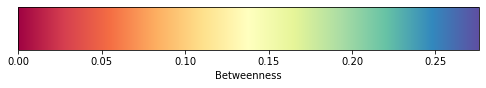

NGLWidget()

In [191]:
from IPython.display import display, HTML

CSS = """
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

#Draw a color bar for the edge coloring,
#(nglview does not seem to support this yet)
drawEdgeColorBar(tempCmat,maskInds=nzInds,
                 cmap=tempCmap,label='Betweenness',
                 cNorm=cNorm,
                 orientation='horizontal')

#Render the filtered interaction network using nglview with
#the edge width and colormaps generated above
struc=strucDict[list(strucDict.keys())[0]]
view=nv.show_pytraj(struc)
view.clear_representations()
#for res in sourceSet:
#    view.add_representation('spacefill',selection=str(res+1)+' and .CA')
#for res in targetSet:
#    view.add_representation('spacefill',selection=str(res+1)+' and .CA')
#view.add_representation('line',selection='backbone',alpha=.5)
drawProtCorrMat(protStruc=struc,corrMat=plotMat,ngViewOb=view,
                    frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
                    undirected=True)
view

In [203]:
testMat=np.array(copy.copy(btwMat+btwMat.T))
btwCut=np.exp(-(np.max(np.array(wMat.todense())[pathNz])+1))
testMat=testMat*(testMat>(btwCut))
testNz=np.nonzero(testMat)
testMat[testNz]=-np.log(testMat[testNz])
print("Btw Cut Val: {:.3e}; Shortest Path Distance: {:.3f}".format(
          btwCut,sp.sparse.csgraph.shortest_path(testMat)[49,432]))

Btw Cut Val: 7.124e-03; Shortest Path Distance: 15.275


In [281]:
plotMat=np.array(np.abs(btwMat+btwMat.T))
#plotMat=plotMat*((plotMat)>btwCut)

print("Nedges=",len(np.nonzero(plotMat)[0]))

nzInds=np.nonzero(plotMat)

#Create a color map for edges based on log(abs(E_Interact.Mean))
tempCmap=matplotlib.cm.get_cmap('plasma',2048)
tempCmat=np.array(plotMat)
vMin=np.min(tempCmat)
vCenter=np.median(tempCmat[nzInds])
vMax=np.max(tempCmat)
cNorm=matplotlib.colors.DivergingNorm(vmin=vMin,vcenter=vCenter,vmax=vMax)
#tempCmat[nzInds]=np.log(tempCmat[nzInds])
edgeColors=getCorrNetEdgeColors(tempCmat,maskInds=nzInds,cmap=tempCmap,
                                cNorm=cNorm)

#Compute widths for edges based on lob(abs(E_Interact.Mean))
#rMin and rMax set minimum and maximum edgewidths
#edgwidth will then interpolate linearly between those two
#bounds.
eMin=.0625
eMax=0.375
radiiMat=getCorrNetEdgeRadii(plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)

Nedges= 3988


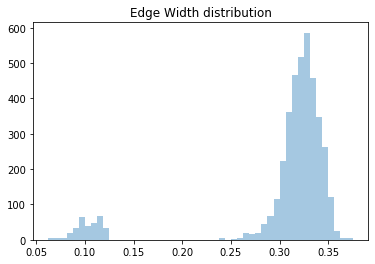

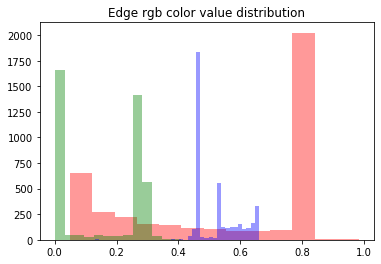

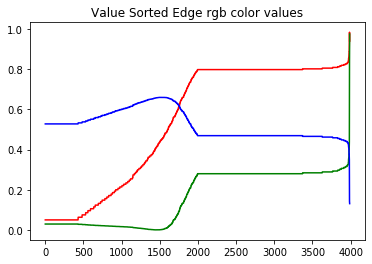

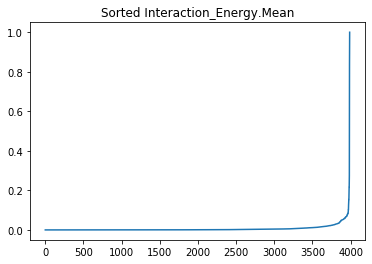

In [282]:
#Plot distribution histograms for edge widths and edge color rgb values
sns.distplot(radiiMat[np.nonzero(radiiMat)].flatten(),
             kde=False)
plt.title('Edge Width distribution')
plt.show()

clist=['red','green','blue']
for ii in np.arange(3):
    sns.distplot(edgeColors[:,:,ii][np.nonzero(edgeColors[:,:,ii])].flatten(),
                 kde=False,color=clist[ii])
plt.title('Edge rgb color value distribution')
plt.show()

sortArr=np.argsort(tempCmat[np.nonzero(tempCmat)])
sortedInds=np.array(list(zip(nzInds[0],nzInds[1])))[sortArr]
sortedNzInds=(sortedInds[:,0],sortedInds[:,1])

clist=['red','green','blue']
for ii in np.arange(3):
    plt.plot(edgeColors[:,:,ii][sortedNzInds],c=clist[ii])
plt.title('Value Sorted Edge rgb color values')
plt.show()

plt.plot(tempCmat[sortedNzInds])
plt.title('Sorted Interaction_Energy.Mean')
plt.show()

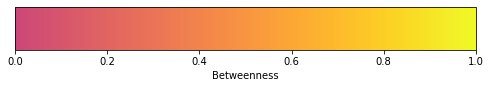

NGLWidget()

In [283]:
from IPython.display import display, HTML

CSS = """
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

#Draw a color bar for the edge coloring,
#(nglview does not seem to support this yet)
drawEdgeColorBar(tempCmat,maskInds=nzInds,
                 cmap=tempCmap,label='Betweenness',
                 cNorm=cNorm,
                 orientation='horizontal')

#Render the filtered interaction network using nglview with
#the edge width and colormaps generated above
struc=strucDict[list(strucDict.keys())[0]]
view=nv.show_pytraj(struc)
view.clear_representations()
for res in sourceSet:
    view.add_representation('spacefill',selection=str(res+1)+' and .CA')
for res in targetSet:
    view.add_representation('spacefill',selection=str(res+1)+' and .CA')
view.add_representation('cartoon',selection='backbone',alpha=.5)
drawProtCorrMat(protStruc=struc,corrMat=plotMat,ngViewOb=view,
                    frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
                    undirected=True)
view

In [215]:
print("top 100 energy weighted paths convergence: %.3e"%alphas[99])
print("top 100 energy betweenness paths convergence: %.3e"%btwAlphas[99])

top 100 energy weighted paths convergence: 1.137e-04
top 100 energy betweenness paths convergence: 1.248e-04


In [155]:
def pathList_to_edgeSetInds(pathList,undirected=True,sep='_'):
    edgeList=[]
    for path in pathList:
        edgeList=np.unique(np.concatenate([
            edgeList,
            [sep.join(list(map(str,edgeInds))) \
             for edgeInds in zip(path[:-1],path[1:])]
        ]))
        if undirected:
            edgeList=np.unique(np.concatenate([
            edgeList,
            [sep.join(list(map(str,edgeInds))) \
             for edgeInds in zip(path[1:],path[:-1])]
        ]))
    eInds=np.array(list(map(lambda x: x.split(sep),edgeList)),dtype=int)
    return((eInds[:,0],eInds[:,1]))

In [27]:
topPaths=pathList[:100]
topPathEdges=pathList_to_edgeSetInds(topPaths)

system='igps'
variant='apo'
nRes=454
Tsim=310.15
kb=0.0019872041
magCut=kb*Tsim*1.0
seqDelta=0
#filter out desired interaction energy edges based
#for the given system based upon energy and
#sequence delta cutoffs
matData=sigData[
    (sigData['System']==system) & \
    (sigData['Variant']==variant) & \
    #((sigData['ResNum_1']-sigData['ResNum_2'])<seqDelta) &
    ((sigData['E_Interact.Mean'].abs() - sigData['E_Interact.Std_Err']) > magCut)]
tempMat=sp.sparse.coo_matrix(
    (matData['E_Interact.Mean'],
     (matData['ResNum_1']-1,matData['ResNum_2']-1)))

plotMat=np.zeros(tempMat.shape)
plotMat[topPathEdges]=tempMat.todense()[topPathEdges]

nzInds=np.nonzero(plotMat)

#Create a color map for edges based on log(abs(E_Interact.Mean))
tempCmap=matplotlib.cm.get_cmap('Spectral',2048)
tempCmat=np.array(plotMat)
vMin=np.min(tempCmat)
vCenter=0
vMax=np.max(tempCmat)
cNorm=matplotlib.colors.DivergingNorm(vmin=vMin,vcenter=vCenter,vmax=vMax)
#tempCmat[nzInds]=np.log(tempCmat[nzInds])
edgeColors=getCorrNetEdgeColors(tempCmat,maskInds=nzInds,cmap=tempCmap,
                                cNorm=cNorm)

#Compute widths for edges based on lob(abs(E_Interact.Mean))
#rMin and rMax set minimum and maximum edgewidths
#edgwidth will then interpolate linearly between those two
#bounds.
eMin=.0625
eMax=0.5
radiiMat=getCorrNetEdgeRadii(plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)

NameError: name 'pathList' is not defined

In [28]:
#Plot distribution histograms for edge widths and edge color rgb values
sns.distplot(radiiMat[np.nonzero(radiiMat)].flatten(),
             kde=False)
plt.title('Edge Width distribution')
plt.show()

clist=['red','green','blue']
for ii in np.arange(3):
    sns.distplot(edgeColors[:,:,ii][np.nonzero(edgeColors[:,:,ii])].flatten(),
                 kde=False,color=clist[ii])
plt.title('Edge rgb color value distribution')
plt.show()

sortArr=np.argsort(tempCmat[np.nonzero(tempCmat)])
sortedInds=np.array(list(zip(nzInds[0],nzInds[1])))[sortArr]
sortedNzInds=(sortedInds[:,0],sortedInds[:,1])

clist=['red','green','blue']
for ii in np.arange(3):
    plt.plot(edgeColors[:,:,ii][sortedNzInds],c=clist[ii])
plt.title('Value Sorted Edge rgb color values')
plt.show()

plt.plot(tempCmat[sortedNzInds])
plt.title('Sorted Edge Values')
plt.show()

NameError: name 'radiiMat' is not defined

sources:  [49]
targets:  [432]


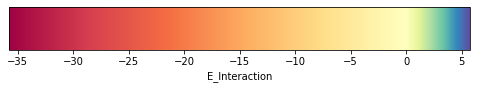

NGLWidget()

In [269]:
from IPython.display import display, HTML

CSS = """
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

print("sources: ",sourceSet)
print("targets: ",targetSet)
#Draw a color bar for the edge coloring,
#(nglview does not seem to support this yet)
drawEdgeColorBar(tempCmat,maskInds=nzInds,
                 cmap=tempCmap,label='E_Interaction',
                 cNorm=cNorm,
                 orientation='horizontal')

#Render the filtered interaction network using nglview with
#the edge width and colormaps generated above
struc=strucDict[list(strucDict.keys())[0]]
view=nv.show_pytraj(struc)
view.clear_representations()
for res in sourceSet:
    view.add_representation('spacefill',selection=str(res+1)+" and .CA")
for res in targetSet:
    view.add_representation('spacefill',selection=str(res+1)+" and .CA")
view.add_representation('line',selection="backbone",alpha=.5)
drawProtCorrMat(protStruc=struc,corrMat=plotMat,ngViewOb=view,
                    frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
                    undirected=True)
view

In [275]:
topPaths=btwPathList[:100]
topPathEdges=pathList_to_edgeSetInds(topPaths)
tempMat=copy.copy(btwMat)
tempMat=tempMat+tempMat.T
plotMat=np.zeros(tempMat.shape)
plotMat[topPathEdges]=tempMat[topPathEdges]

nzInds=np.nonzero(plotMat)

#Create a color map for edges based on log(abs(E_Interact.Mean))
tempCmap=matplotlib.cm.get_cmap('plasma',2048)
tempCmat=np.array(tempMat) #plotMat)
vMin=np.min(tempCmat[nzInds])
vCenter=np.median(tempCmat[nzInds])
vMax=np.max(tempCmat[nzInds])
cNorm=matplotlib.colors.DivergingNorm(vmin=vMin,vcenter=vCenter,vmax=vMax)
#tempCmat[nzInds]=np.log(tempCmat[nzInds])
edgeColors=getCorrNetEdgeColors(tempCmat,maskInds=nzInds,cmap=tempCmap,
                                cNorm=cNorm)

#Compute widths for edges based on lob(abs(E_Interact.Mean))
#rMin and rMax set minimum and maximum edgewidths
#edgwidth will then interpolate linearly between those two
#bounds.
eMin=.0625
eMax=0.5
radiiMat=getCorrNetEdgeRadii(plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)

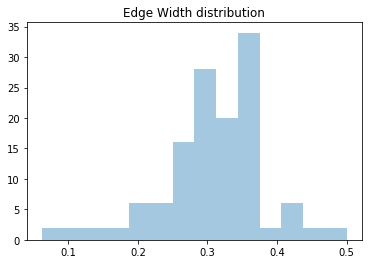

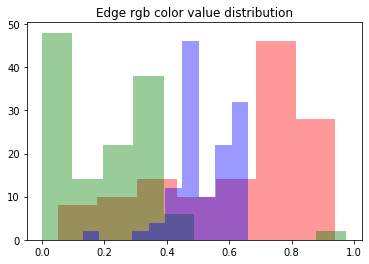

IndexError: index 3668 is out of bounds for axis 0 with size 130

In [276]:
#Plot distribution histograms for edge widths and edge color rgb values
sns.distplot(radiiMat[np.nonzero(radiiMat)].flatten(),
             kde=False)
plt.title('Edge Width distribution')
plt.show()

clist=['red','green','blue']
for ii in np.arange(3):
    sns.distplot(edgeColors[:,:,ii][np.nonzero(edgeColors[:,:,ii])].flatten(),
                 kde=False,color=clist[ii])
plt.title('Edge rgb color value distribution')
plt.show()

sortArr=np.argsort(tempCmat[np.nonzero(tempCmat)])
sortedInds=np.array(list(zip(nzInds[0],nzInds[1])))[sortArr]
sortedNzInds=(sortedInds[:,0],sortedInds[:,1])

clist=['red','green','blue']
for ii in np.arange(3):
    plt.plot(edgeColors[:,:,ii][sortedNzInds],c=clist[ii])
plt.title('Value Sorted Edge rgb color values')
plt.show()

plt.plot(tempCmat[sortedNzInds])
plt.title('Sorted Edge Values')
plt.show()

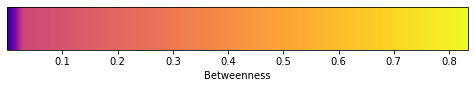

NGLWidget()

In [280]:
from IPython.display import display, HTML

CSS = """
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

#Draw a color bar for the edge coloring,
#(nglview does not seem to support this yet)
drawEdgeColorBar(tempCmat,maskInds=nzInds,
                 cmap=tempCmap,label='Betweenness',
                 cNorm=cNorm,
                 orientation='horizontal')

#Render the filtered interaction network using nglview with
#the edge width and colormaps generated above
struc=strucDict[list(strucDict.keys())[0]]
view=nv.show_pytraj(struc)
view.clear_representations()
for res in sourceSet:
    view.add_representation('spacefill',selection=str(res+1)+" and .CA")
for res in targetSet:
    view.add_representation('spacefill',selection=str(res+1)+" and .CA")
view.add_representation('line',selection="backbone",alpha=.5)
drawProtCorrMat(protStruc=struc,corrMat=plotMat,ngViewOb=view,
                    frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
                    undirected=True)
view

In [41]:
tempStr=None
if tempStr:
    print(tempStr)

In [46]:
def bokeh_dataTable_heatMap(plotData,Xcol,Ycol,dataCol,
                            width=640,height=640,
                            rectheight=1,rectwidth=1,
                            colorMap=sns.color_palette("coolwarm", n_colors=256).as_hex(),
                            title=None,
                            axisFontSize="14pt",
                            vmin=None,vmax=None):
    
    if vmin is None:
        eMin=plotData[dataCol].min()
    else:
        eMin=vmin
    if vmax is None:
        eMax=plotData[dataCol].max()
    else:
        eMax=vmax
        
    plotData['ColorWeight']=plotData[dataCol] #.map(lambda x: cNorm(x)) #.map(np.log10)
    
    #tempCmat=sp.sparse.coo_matrix((
    #    plotData['ColorWeight'],
    #    (plotData.ResNum_1,plotData.ResNum_2)),shape=454,454)
    #tempCmap=matplotlib.cm.get_cmap('Spectral',11)
    
    #drawEdgeColorBar(tempCmat,maskInds=nzInds,
    #             cmap=tempCmap,label='E_Interaction.Mean (kcal/mol)',
    #             cNorm=cNorm,
    #             orientation='horizontal')
    
    p=bk.plotting.figure(
        plot_width=width,plot_height=height,
        #text_font_size='14pt',
        title="{matName} Interaction Energy Heat Map".format(
            matName='.'.join([
                system,variant])))
    
    if title:
        p.add_layout(Title(text=title),'above')
        
    p.xaxis.major_label_text_font_size=axisFontSize
    p.yaxis.major_label_text_font_size=axisFontSize
    
    src=ColumnDataSource(plotData)
    mapper=linear_cmap(field_name='ColorWeight',
                       palette=colorMap,
                       low=eMin,
                       high=eMax,
                      )
    
    cbMapper=LinearColorMapper(palette=colorMap,
                               low=eMin,
                               high=eMax)
    color_bar = ColorBar(color_mapper=cbMapper, ticker= BasicTicker(),
                     location=(0,0))

    p.add_layout(color_bar, 'right')

    p.rect(source=src,width=rectwidth,height=rectheight, x=Xcol,y=Ycol,
             fill_color=mapper,color=mapper)

    
    
    hover=HoverTool()
    hover.tooltips=[
        (colName,"@{"+"{colName}".format(colName=colName)+"}")
        for colName in src.data.keys()
    ]
    print(hover.tooltips)
    p.add_tools(hover)

    output_notebook()
    show(p)

In [43]:
sigData.head()

,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,247,MET,ASN,-1.124520,0.114242


In [47]:
@interact_manual
def plot_mat(
    system=sigData.System.unique(),
    variant=sigData.Variant.unique(),
    magCut=widgets.FloatSlider(min=.01,max=100.,step=.01,value=2.0,
                               description='Energy_Cut')):
    
    colorMap=np.flip(sns.color_palette("plasma", n_colors=256).as_hex())
    
    plotData=sigData[
        (sigData.System==system) & \
        (sigData.Variant==variant) & \
        ((sigData.ResNum_1 - sigData.ResNum_2).abs() > 0) &
        ((sigData['E_Interact.Mean'].abs()-sigData['E_Interact.Std_Err'])>magCut)]
    bokeh_dataTable_heatMap(plotData,Xcol="ResNum_1",Ycol="ResNum_2",dataCol="E_Interact.Mean",
                            width=640,height=640,
                            colorMap=np.flip(sns.color_palette("coolwarm", n_colors=256).as_hex()),
                            title=None,
                            axisFontSize="14pt",
                            vmin=None,vmax=None)

interactive(children=(Dropdown(description='system', options=('igps',), value='igps'), Dropdown(description='v…

In [8]:
sigData.head()

,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err
0,igps,apo,1,1,MET,MET,-32.826080,0.364449
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238
4,igps,apo,1,247,MET,ASN,-1.124520,0.114242


In [10]:
matGroups=sigData.groupby(['System','Variant'])

sourceSet=[49]
targetSet=[432]

nRes=454
minEVal=1E-10 #ensure edges never have exactly zero interaction energy (division error)
netDataTables=[]
for groupName,groupData in matGroups:
    print("working on ",*groupName)
    weightMat=sp.sparse.coo_matrix(
                ((groupData['E_Interact.Mean'].abs()+minEVal)**-1,
                 (groupData['ResNum_1']-1,groupData['ResNum_2']-1)),
                shape=(nRes,nRes)).todense()
    btwMat=correlation_data_utilities.getBtwMat(
        mat=weightMat,sources=sourceSet,targets=targetSet,
        verbose=False,verboseLevel=0,
        useProgressBar=True,pbarFun=tqdm.tqdm_notebook)
    if np.sum(btwMat-btwMat.T)>0:
        btwMat=btwMat+btwMat.T
    tempTable=groupData.copy()
    tempTable['Betweenness']=tempTable[['ResNum_1','ResNum_2']].apply(
        lambda x: btwMat[x[0]-1,x[1]-1],axis=1)
    netDataTables.append(tempTable.copy())
netDataTable=pd.concat(netDataTables)
netDataTable.head()

working on  igps apo
working on  igps holo


,System,Variant,ResNum_1,ResNum_2,ResName_1,ResName_2,E_Interact.Mean,E_Interact.Std_Err,Betweenness
0,igps,apo,1,1,MET,MET,-32.826080,0.364449,0.000000
1,igps,apo,1,2,MET,LEU,-27.286881,0.088237,0.000149
2,igps,apo,1,3,MET,ALA,-0.529824,0.032005,0.002782
3,igps,apo,1,4,MET,LYS,-0.196490,0.055238,0.031170
4,igps,apo,1,247,MET,ASN,-1.124520,0.114242,0.000246


In [31]:
nodeBtwDataTable=netDataTable.drop(
        columns=[colName for colName in netDataTable.columns \
                 if 'E_Interact' in colName]
    )[['System','Variant','ResNum_1','ResName_1','Betweenness']].groupby(
        ['System','Variant','ResNum_1','ResName_1']
    ).agg(sum).reset_index()
nodeBtwDataTable['NetworkName']=nodeBtwDataTable[['System','Variant']].apply(
    lambda x: '.'.join(x),axis=1)
nodeBtwDataTable=nodeBtwDataTable.drop(columns=['System','Variant'])
nodeBtwDataTable=nodeBtwDataTable.pivot(
    index='ResNum_1',columns='NetworkName',values='Betweenness')
netNames=nodeBtwDataTable.NetworkName.unique()
nodeBtwDataTable.columns=np.array(nodeBtwDataTable.columns.map(str))
nodeBtwDataTable=nodeBtwDataTable.reset_index()
nodeBtwDataTable.head()

,ResNum_1,igps.apo,igps.holo
0,1,0.068127,0.057397
1,2,0.046353,0.041591
2,3,0.093960,0.103937
3,4,0.099892,0.082210
4,5,0.089281,0.085701


In [35]:
nodeDeltaTable=nodeBtwDataTable.melt(id_vars=['ResNum_1','igps.apo'],
                                     var_name='testNetworkName',value_name='testNetworkBetweenness')
nodeDeltaTable['Delta']=nodeDeltaTable[['igps.apo','testNetworkBetweenness']].apply(
    lambda x: x[1]-x[0],axis=1)
nodeDeltaTable['RelativeDelta']=nodeDeltaTable[['igps.apo','testNetworkBetweenness']].apply(
    lambda x: (x[1]-x[0])/np.max(x),axis=1)
nodeDeltaTable.head()

,ResNum_1,igps.apo,testNetworkName,testNetworkBetweenness,Delta,RelativeDelta
0,1,0.068127,igps.holo,0.057397,-0.010730,-0.157498
1,2,0.046353,igps.holo,0.041591,-0.004762,-0.102741
2,3,0.093960,igps.holo,0.103937,0.009978,0.095998
3,4,0.099892,igps.holo,0.082210,-0.017682,-0.177009
4,5,0.089281,igps.holo,0.085701,-0.003580,-0.040102


In [38]:
import nglview as nv

In [40]:
import pytraj as pt
strucDataDir='energy_topology'
systems=['igps']
variants=['apo','holo']

strucFileNameStr="{system}.prot_lig_{variant}.pdb"

subDirStr='{system}.{variant}'

strucDict={}
for system in systems:
    for variant in variants:
        subDir=subDirStr.format(system=system,variant=variant)
        strucFileName=strucFileNameStr.format(system=system,variant=variant)
        strucFilePath='/'.join([strucDataDir,subDir,strucFileName])
        strucKey=subDir
        print("loading",strucKey)
        strucDict[strucKey]=pt.load(strucFilePath)
print(strucDict)

loading igps.apo
loading igps.holo
{'igps.apo': pytraj.Trajectory, 1 frames: 
Size: 0.000161 (GB)
<Topology: 7225 atoms, 456 residues, 4 mols, PBC with box type = ortho>
           , 'igps.holo': pytraj.Trajectory, 1 frames: 
Size: 0.000163 (GB)
<Topology: 7281 atoms, 455 residues, 3 mols, PBC with box type = ortho>
           }


In [51]:
refNet='igps.apo'
struc=strucDict[refNet]
sourceResids=np.array(sourceSet,dtype=int)
targetResids=np.array(targetSet,dtype=int)

In [ ]:
matplotlib.collections

In [65]:
@interact
def render_difference(testSystem=widgets.Dropdown(
                        options=nodeDeltaTable.testNetworkName.unique()),
                        colorMap=['viridis', 'plasma', 'inferno', 'magma', 'cividis',
                                  'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
                                  'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'],
                        colorRange=widgets.FloatRangeSlider(min=-1,max=1,value=(-.01,.01)),
                        valCol=[refNet,'testNetworkBetweenness',
                                'Delta','RelativeDelta'],
                        showRelativeDelta=False):
    plotData=nodeDeltaTable.query('testNetworkName == "%s"'%testSystem)
    
    plotTitle={
            refNet:"Reference System (%s)\nNode Betweenness"%refNet,
           'testNetworkBetweenness':"Test System (%s)\nNode Betweenness"%testSystem,
           'Delta':'Node Betweenness Delta\n%s - %s'%(testSystem,refNet),
           'RelativeDelta':'Node Betweenness Relative Delta\n%s - %s'%(testSystem,refNet)
        }[valCol]
    colorVals=plotData[valCol].to_list()

    cMap=matplotlib.cm.get_cmap(colorMap,256)
    cNorm=matplotlib.colors.Normalize(colorRange[0],colorRange[1])
    
    colorList=[
        x.replace('#','0x') for x in \
        map(matplotlib.colors.to_hex,
            cMap(cNorm(
                    colorVals
                 )))]

    correlation_data_utilities.drawEdgeColorBar(
         np.array([colorVals]),maskInds=None,
         cmap=cMap,
         cNorm=cNorm,
         ax=None,
         label=plotTitle,
         label_size=24,
         barSize=[18,5],
         orientation='horizontal',
         verbose=False)
    view=nv.show_pytraj(struc)
    view.clear_representations()
    view.add_cartoon('protein')
    view._set_color_by_residue(colorList)
    for resid in sourceResids+1:
        view.add_representation('spacefill',selection='%g'%resid,alpha=.5)
    for resid in targetResids+1:
        view.add_representation('spacefill',selection='%g'%resid,alpha=.5)
    display(view,width=800,height=800)

interactive(children=(Dropdown(description='testSystem', options=('igps.holo',), value='igps.holo'), Dropdown(…